# Actor-Critic Method

This code is an example using Actor-Critic Method [This website](https://medium.com/towards-data-science/understanding-actor-critic-methods-931b97b6df3f).

There are multiple Actor-Critic Methods, but here we focus on Advantage Actor-Critic Method (a.k.a., A2C).


In [8]:
import sys
import torch  
import gym
import numpy as np  

import torch.nn            as nn
import torch.optim         as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import pandas as pd


# Actor-Critic Neural Network.

We merge the two networks in a single class, although we can separate these two. Since we have merged the two Actor and Critic networks, they are updated in synchrony. 
A method which asynchronously updates the two networks are called the "Asynchronous Advantage Actor-Critic Method" (a.k.a. A3C), where the details are in [this website](https://medium.com/@shagunm1210/implementing-the-a3c-algorithm-to-train-an-agent-to-play-breakout-c0b5ce3b3405).

### Actor Network
The actor network maps state to action, hence the input is the number of states of the example, $n_s$ and the output is the number of actions $n_a$.

### Critic Network
The critic network maps state to a scalar real value, which is known to be the quality of the state.


In [9]:
class ActorCritic(nn.Module):

    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):

        super( ActorCritic, self ).__init__( )

        self.num_actions = num_actions

        self.actor_linear1  = nn.Linear(  num_inputs, hidden_size )
        self.actor_linear2  = nn.Linear( hidden_size, num_actions )

        self.critic_linear1 = nn.Linear(  num_inputs, hidden_size )
        self.critic_linear2 = nn.Linear( hidden_size,           1 )

    
    def forward(self, state):

        # Parsing the input before forwarding in the network
        state = Variable( torch.from_numpy( state ).float( ).unsqueeze( 0 ) )

        # The critic (value) network uses a relu function 
        value = F.relu( self.critic_linear1( state ) )
        value = self.critic_linear2( value )

        # The actor (policy) network uses a relu + softmax function
        policy_dist = F.relu( self.actor_linear1( state ) )
        policy_dist = F.softmax( self.actor_linear2( policy_dist ), dim = 1 )

        return value, policy_dist



# The Advantage Actor-Critic (A2C) Method


In [12]:
# Hyperparameters
hidden_size   = 256     # The size of the intermediate layer of the neural network
learning_rate = 3e-4    # For the adam optimizer 

# Constants
GAMMA        = 0.99     # Discount Factor 
num_steps    = 300      # The number of steps for a single trial (episode)
max_episodes = 3000     # The maximum number of trials (episodes)

def a2c( env ):

    num_inputs   = env.observation_space.shape[0  ]
    num_outputs  = env.action_space.n
    
    actor_critic = ActorCritic( num_inputs, num_outputs, hidden_size )
    ac_optimizer = optim.Adam( actor_critic.parameters( ), lr = learning_rate )


    all_lengths     = []
    all_rewards     = []

    average_lengths = []
    entropy_term    = 0

    for episode in range( max_episodes ):
        log_probs = []
        values    = []
        rewards   = []

        state = env.reset()

        for steps in range( num_steps ):

            value, policy_dist = actor_critic.forward( state )

            value = value.detach( ).numpy( )[ 0,0 ]
            dist  = policy_dist.detach( ).numpy( ) 

            action   = np.random.choice( num_outputs, p = np.squeeze( dist ) )
            log_prob = torch.log( policy_dist.squeeze( 0 )[ action ] )
            entropy  = -np.sum( np.mean( dist ) * np.log( dist ) ) 

            # Run a single step for the simulation
            new_state, reward, done, _ = env.step(action)

            rewards.append( reward )
            values.append( value )
            log_probs.append( log_prob )
            
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward( new_state )
                Qval    = Qval.detach( ).numpy( )[0,0]

                all_rewards.append( np.sum( rewards ) )
                all_lengths.append( steps )

                average_lengths.append( np.mean( all_lengths[ -10: ] ) )

                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like( values )
        for t in reversed( range( len( rewards ) ) ):
            Qval       = rewards[ t ] + GAMMA * Qval
            Qvals[ t ] = Qval
  
        #update actor critic
        values    = torch.FloatTensor( values ) 
        Qvals     = torch.FloatTensor( Qvals  )
        log_probs = torch.stack( log_probs )
        
        advantage   = Qvals - values
        actor_loss  = ( -log_probs * advantage ).mean( )
        critic_loss = 0.5 * advantage.pow(2).mean( )
        

        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term
        
        # Back propagation
        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()


    # Plot results
    smoothed_rewards = pd.Series.rolling( pd.Series( all_rewards ), 10 ).mean( )
    smoothed_rewards = [ elem for elem in smoothed_rewards ]
    
    plt.plot( all_rewards)
    plt.plot( smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()        

episode: 0, reward: 15.0, total length: 14, average length: 14.0 
episode: 10, reward: 21.0, total length: 20, average length: 25.6 
episode: 20, reward: 63.0, total length: 62, average length: 24.0 
episode: 30, reward: 49.0, total length: 48, average length: 29.3 
episode: 40, reward: 20.0, total length: 19, average length: 23.3 
episode: 50, reward: 21.0, total length: 20, average length: 27.0 
episode: 60, reward: 24.0, total length: 23, average length: 29.4 
episode: 70, reward: 18.0, total length: 17, average length: 22.5 
episode: 80, reward: 58.0, total length: 57, average length: 24.6 
episode: 90, reward: 47.0, total length: 46, average length: 29.6 
episode: 100, reward: 9.0, total length: 8, average length: 34.1 
episode: 110, reward: 25.0, total length: 24, average length: 17.9 
episode: 120, reward: 20.0, total length: 19, average length: 28.9 
episode: 130, reward: 60.0, total length: 59, average length: 29.3 
episode: 140, reward: 21.0, total length: 20, average length:

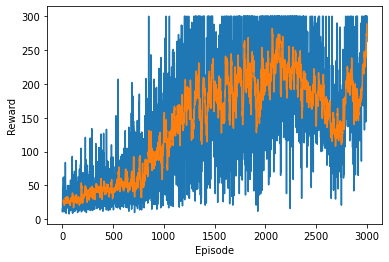

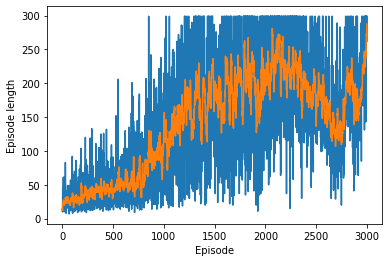

In [13]:
env = gym.make("CartPole-v1")
a2c(env)    

# References 

[1] [Great post](https://danieltakeshi.github.io/2018/06/28/a2c-a3c/)